# Data 401 Project 3

In [1]:
from funcs import *
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import random

import sys

### Reading in the Data

In [2]:
russia_df = pd.read_csv("russian_housing.csv")

In [3]:
len(russia_df)*.1

3047.1000000000004

In [4]:
ind = list(russia_df.index)
random.shuffle(ind)

# we will use a test set of 10% of the data
test_ind = ind[:3050]
train_ind = ind[3050:]

In [5]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(russia_df.drop(["timestamp", "price_doc"], axis=1).iloc[train_ind])
X_test_std = scaler.transform(russia_df.drop(["timestamp", "price_doc"], axis=1).iloc[test_ind])
y_train = russia_df["price_doc"].iloc[train_ind]
y_test = russia_df["price_doc"].iloc[test_ind]

In [6]:
scaler2 = StandardScaler()
X_std = scaler2.fit_transform(russia_df.drop(["timestamp", "price_doc"], axis=1))
y = russia_df["price_doc"]

<AxesSubplot:ylabel='Frequency'>

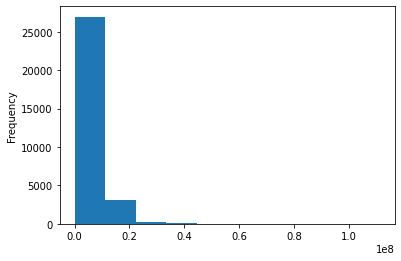

In [7]:
y.plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

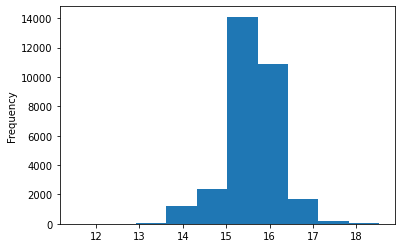

In [8]:
np.log(y).plot(kind="hist")

In [9]:
y_log = np.log(y)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

We then decided to use the log of y as the results are more normally distributed.

### Evaluation Metrics

In [10]:
def get_mse(y, y_pred):
    return np.mean(np.square(y-y_pred))

In [11]:
def get_mae(y, y_pred):
    return np.mean(np.absolute(y-y_pred))

## Compare to Linear Regression

In [12]:
class LR:
    
    def fit(self, X_train, y_train):
        # create vector of ones...
        ones = np.ones(shape=len(X_train))[..., None]
        #...and add to feature matrix
        X = np.concatenate((ones, X_train), 1)
        #calculate coefficients using closed-form solution
        self.coeffs = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y_train)
        
    def predict(self, X_test):
        ones = np.ones(shape=len(X_test))[..., None]
        X_test = np.concatenate((ones, X_test), 1)
        y_hat = X_test.dot(self.coeffs)
        return y_hat

### Linear Regression MAE

In [13]:
lr = LR()
lr.fit(X_train_std, y_train_log)
mae = get_mae(y_test, np.exp(lr.predict(X_test_std)))
print('Mean absolute error: $%0.2f'%(mae))

Mean absolute error: $8968729.22


### Linear Regression MSE

In [14]:
mse = get_mse(y_test, np.exp(lr.predict(X_test_std)))
print('MSE:', mse)

MSE: 1.4042960337829707e+17


Now that we have our baseline from the linear regression, it is time to develop a neural network implementations to get better results.

# Neural Network

In [15]:
class NeuralNetwork:
    
    def __init__(self, layers=None, nodes=None, nnodes=None, 
                 activations=[], activationFn="relu", batchSize=50, 
                 lr=.001, lr_type="constant", power_t=.5,
                 annealing_rate=.999, max_epoch=200, momentum=.9, 
                 tol=0.0001, alpha=.0001, shuffle=False, 
                 early_stopping=False, num_epochs_stop=50, verbose=True):
        
        if layers != None:
            self.layers = layers # total number of hidden layers
        else:
            self.layers = len(nodes)

        # an int array of size [0, ..., Layers + 1]
        # Nodes[0] shall represent the input size (typically 50)
        # Nodes[Layers + 1] shall represent the output size (typically 1)
        # all other Nodes represent the number of nodes (or width) in the hidden layer i
        self.nodes = nodes
        if nodes != None:
            self.nodes.insert(0, batchSize)
            self.nodes.append(1)
        
        # alternative to nodes where each hidden layer of the nueral network is the same size
        self.nnodes = nnodes
        if nnodes != None:
            self.nodes = []
            self.nodes.append(batchSize)
            for i in range(layers):
                self.nodes.append(nnodes)
            self.nodes.append(1)
        
        # activations[i] values are labels indicating the activation function used in layer i
        self.activations = activations
        self.activationFn = activationFn
        if activationFn != "":
            self.activations = [activationFn] * self.layers
        
        self.batchSize = batchSize
        self.lr = lr
        self.lr_type = lr_type
        self.power_t = power_t
        self.annealing_rate = annealing_rate
        self.max_epoch = max_epoch
        self.mu = momentum
        self.tol = tol
        self.alpha = alpha
        self.shuffle = shuffle
        self.verbose = verbose
        
        if early_stopping == False:
            self.num_epochs_stop = max_epoch
        else:
            self.num_epochs_stop = num_epochs_stop
    
        self.layer_values = [None] * (self.layers + 2)
        self.iters = 0
        self.epochs = 0
                
    def validateHyperParams(self):
        
        if self.layers != (len(self.nodes) - 2):
            raise ValueError("layers must be equal to the number of hidden layers, got %s." % self.layers)
        if self.nnodes != None and self.nnodes <= 0:
            raise ValueError("nnodes must be > 0, got %s." % self.nnodes)
        if self.lr <= 0 or self.lr > 1:
            raise ValueError("lr must be in (0, 1], got %s." % self.lr)
            
        if self.lr_type not in ["constant", "invscaling", "annealing", "adaptive"]:
            raise ValueError("lr_type is not valid" % self.lr_type
                            + "\nAvailable lr types: constant, invscaling, adaptive")
            
        if self.max_epoch <= 0:
            raise ValueError("max_iter must be > 0, got %s." % self.max_epoch)
               
        activation_functions = list(ACTIVATIONS.keys())
        if self.activationFn != "":
            if self.activationFn not in activation_functions:
                raise ValueError("%s is not an activation function" % self.activationFn
                                + "\nAvailable activation functions: relu, leaky_relu, sigmoid, tanh")
    
    def initialize_weights(self, M):
        weights = []
        
        for i in range(self.layers + 1):
            if i == 0:
                input_size = M # special case for w1
            else:
                input_size = self.nodes[i]
            output_size = self.nodes[i + 1]
            
            # Xavier (Glorot) Initialization
            if self.activationFn == "tanh":
                target_variance = 2 / (input_size + output_size)
                w_i = np.random.normal(loc= 0, scale = np.sqrt(target_variance), size=(input_size, output_size))
            # He Initialization
            elif self.activationFn == "relu":
                target_variance = 2 / input_size
                w_i = np.random.normal(loc= 0, scale = np.sqrt(target_variance), size=(input_size, output_size))
            # Random Uniform
            else:
                w_i = np.random.uniform(-1/np.sqrt(input_size), 1/np.sqrt(input_size))
                #w_i = np.random.normal(size=(input_size, output_size))
            w_i = np.round(w_i, 2)
            w_i[input_size - 1:] = 0 # initialize bias to 0
            weights.append(w_i)
        return weights
    
    # returns the weight term for L2 regularization
    def get_weight_term(self):
        weight_term = 0
        for i in range(len(self.weights)):
            weight_term = np.sum(self.weights[i] ** 2)
        return weight_term
        
    def forward_pass(self, X_batch, y_batch):
        
        self.layer_values[0] = X_batch
        
        # calculate hidden layers
        for i in range(self.layers):
            X = self.layer_values[i]
            weights = self.weights[i]
            h_layer = X.dot(weights)
            
            # apply activation function
            activation_fn = ACTIVATIONS[self.activations[i]]
            activation_fn(h_layer)
            self.layer_values[i + 1] = h_layer
            
        
        # calculate predictions
        X = self.layer_values[self.layers] # values in last hidden layer
        weights = self.weights[self.layers]
        y_pred = X.dot(weights)
        y_pred = y_pred.flatten()
        
        # calculate the l2 loss
        l2_loss = 0
        # only need predictions once we have fit the data
        if isinstance(y_batch, np.ndarray): 
            l2_loss = squared_loss(y_pred, y_batch) # l2
            weight_term = self.get_weight_term()
            l2_loss += self.alpha * weight_term # l2 regularization
            self.layer_values[self.layers + 1] = l2_loss
        
        return l2_loss, y_pred
    
    
    def backward_pass(self, y_pred, y_batch):
        
        # loss layer
        J = squared_loss_derivative(y_pred, y_batch, self.batchSize)
        J = np.reshape(J, (len(J), 1))
        
        J_weights = [None] * (self.layers + 1)
        
        # output layer
        # jacobian w.r.t. weights
        x_t = self.layer_values[self.layers].T
        J_wi = x_t.dot(J)
        J_weights[self.layers] = J_wi
        
        # update jacobian at output layer
        w_t = self.weights[self.layers].T
        w_t = np.delete(w_t, w_t.shape[1] - 1, 1) # take out the bias
        J = np.dot(J, w_t)
        zeros = [0] * len(J)
        zeros = np.reshape(zeros, (len(J), 1))
        J = np.append(J, zeros, axis=1)
        
        # iterate through hidden layers backwards
        for i in range(self.layers, 0 , -1):
            # update jacobian at activation layer
            d_activation_fn = DERIVATIVES[self.activations[i - 1]]
            d_activation_fn(self.layer_values[i], J)
            
            # hidden layer
            # jacobian w.r.t. weights
            x_t = self.layer_values[i - 1].T
            J_wi = x_t.dot(J)
            J_weights[i - 1] = J_wi
            
            # jacobian w.r.t. inputs
            w_t = self.weights[i - 1].T
            w_t = np.delete(w_t, w_t.shape[1] - 1, 1)
            J = np.dot(J, w_t)
            zeros = [0] * len(J)
            zeros = np.reshape(zeros, (len(J), 1))
            J = np.append(J, zeros, axis=1)
            
            
        # initialize velocity to 0
        if self.epochs == 0 and self.iters == 0:
            self.velocity = []
            for i in range(len(J_weights)):
                n_rows = J_weights[i].shape[0]
                n_cols = J_weights[i].shape[1]
                vel_i = np.zeros((n_rows, n_cols))
                self.velocity.append(vel_i)
        
        for i in range(len(J_weights)):
            self.velocity[i] = self.mu * self.velocity[i] - self.lr * J_weights[i]
            self.weights[i] += self.velocity[i]
      
    
    def fit(self, X_train, y_train):
        
        self.validateHyperParams()
        # convert to numpy arrays
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
            
        if isinstance(y_train, pd.Series):
            y_train = y_train.to_numpy()
            
        # add ones for bias
        ones = [1] * len(X_train)
        ones = np.reshape(ones, (len(X_train), 1))
        X_train = np.append(X_train, ones, axis=1)
        
        # save 10% for validation
        val_rows = round(len(X_train) * .1)
        X_val = X_train[:val_rows, :]
        y_val = y_train[:val_rows]
        
        X_train = X_train[val_rows:, :]
        y_train = y_train[val_rows:]
        
        # initalize weights on first iteration
        M = X_train.shape[1] # M = number of features
        self.weights = self.initialize_weights(M)
        
        best_v_loss = np.inf
        n_epoch_no_change = 0 
        while (self.epochs < self.max_epoch and n_epoch_no_change <= self.num_epochs_stop):
            # ONE EPOCH 
            last_idx = 0
            if self.shuffle == True: # shuffle data after every epoch, if specified 
                np.random.shuffle(X_train)
            while (last_idx < len(X_train)):
                first_idx = self.iters * self.batchSize
                remaining_rows = len(X_train) - first_idx
                last_idx = first_idx + min(self.batchSize, remaining_rows)
                X_batch = X_train[first_idx: last_idx, :]
                y_batch = y_train[first_idx: last_idx]

                loss, y_pred = self.forward_pass(X_batch, y_batch)
                self.backward_pass(y_pred, y_batch)
                self.iters += 1
            
            # trainig and validation loss after one epoch
            t_loss, y_pred = self.forward_pass(X_train, y_train)
            v_loss, y_pred = self.forward_pass(X_val, y_val)
            if self.verbose:
                print("epoch:", self.epochs)
                print("training loss:", t_loss)
                print("validation loss:", v_loss)
            
            self.iters = 0 # start over, next epoch
            self.epochs += 1
            
            # decrease the learning rate by one of three methods, if specified
            if self.lr_type == "invscaling":
                self.lr = self.lr/pow(self.epochs, self.power_t)
            elif self.lr_type == "annealing":
                self.lr = self.lr * self.annealing_rate
            elif self.lr_type == "adaptive":
                if n_epoch_no_change >= 2: 
                    self.lr = self.lr/5
                
            # stops when validation loss doesn't improve for num_epochs_stop
            if best_v_loss - v_loss < self.tol: 
                n_epoch_no_change += 1
            else:
                n_epoch_no_change = 0
            # update best_v_loss
            if v_loss < best_v_loss:
                best_v_loss = v_loss
            
            
        
    def predict(self, X_test):
        
        # convert to numpy array
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.to_numpy()
        
        # add ones for bias
        ones = [1] * len(X_test)
        ones = np.reshape(ones, (len(X_test), 1))
        X_test = np.append(X_test, ones, axis=1)
        
        loss, y_pred = self.forward_pass(X_test, None)
        return y_pred
        

In [ ]:
nodes = [100] # use to specify a number of hidden nodes per layer
batches = [75, 150, 1000, 3000]

means = []
mses = []

for nod in nodes:
    for batch in batches:
        print("Nodes:", nod)
        print("Batch Size:", batch)
        nn = NeuralNetwork(layers=3, nnodes=nod, batchSize=batch, 
                   activationFn="tanh", lr=0.00001, lr_type="constant", 
                   max_epoch=2000, momentum=0.9, early_stopping=True, verbose=False)
        nn.fit(X_std, y_log)
        
        mae = get_mae(y_log, nn.predict(X_std))
        means.append(mae)
        mse = get_mse(y_log, nn.predict(X_std))
        mses.append(mse)

print(means)
print(mses)

Nodes: 100
Batch Size: 75
Nodes: 100
Batch Size: 150


We can see here that a neural network with ____ nodes in each layer and with a batch size of ____ is optimal.

In [18]:
means, mses

([0.3719213974654842,
  0.40464122313609907,
  15.507711550791655,
  15.496401756124515,
  0.37059927448713376,
  0.40061924091584505],
 [0.30738081309640997,
  0.3448503254331879,
  240.89535707146248,
  240.68193902850905,
  0.3019580281590337,
  0.3398968652326514])

In [ ]:
means = []
mses = []

for i in range(1, 6):
    print("Number of layers:", i)
    nn = NeuralNetwork(layers=i, nnodes=75, batchSize=75, 
               activationFn="tanh", lr=0.00001, lr_type="constant", 
               max_epoch=2000, momentum=0.9, early_stopping=True, verbose=False)
    nn.fit(X_std, y_log)

    mae = get_mae(y_log, nn.predict(X_std))
    means.append(mae)
    print(mae)
    mse = get_mse(y_log, nn.predict(X_std))
    mses.append(mse)
    print(mse)

print(means)
print(mses)

Number of layers: 1
0.32878571475904267
0.2653659683032532
Number of layers: 2
0.33078621934338914
0.2630391625102294
Number of layers: 3
0.32166828746298876
0.25342771172128625
Number of layers: 4
0.3290997733116515
0.259221440482325
Number of layers: 5


We can see here that a neural network with 3 hidden layers is optimal

In [ ]:
actives = ["tanh", "sigmoid"]

means = []
mses = []

for active in actives:
    print("Activation Function:", active)
    nn = NeuralNetwork(layers=3, nnodes=75, batchSize=75, 
               activationFn=active, lr=0.000001, lr_type="constant", 
               max_epoch=2000, momentum=0.9, early_stopping=True, verbose=False)
    nn.fit(X_std, y_log)

    mae = get_mae(y_log, nn.predict(X_std))
    means.append(mae)
    print(mae)
    mse = get_mse(y_log, nn.predict(X_std))
    mses.append(mse)
    print(mse)

print(means)
print(mses)

Activation Function: tanh


In [ ]:
Activation Function: relu
1.839555048410389
5.905572357965957
Activation Function: tanh

We can see that a nerual network with ____ as the activation function is the most optimal.

In [ ]:
lrs = [0.000001, 0.0000001]

means = []
mses = []

for l in lrs:
    print("Learning Rate:", l)
    nn = NeuralNetwork(layers=3, nnodes=75, batchSize=75, 
               activationFn="tanh", lr=l, lr_type="constant", 
               max_epoch=2000, momentum=0.9, early_stopping=True, verbose=False)
    nn.fit(X_std, y_log)

    mae = get_mae(y_log, nn.predict(X_std))
    means.append(mae)
    print("MAE:", mae)
    mse = get_mse(y_log, nn.predict(X_std))
    mses.append(mse)
    print("MSE:", mse)

print(means)
print(mses)

Learning Rate: 1e-06


In [ ]:
Learning Rate: 0.0001
MAE: 0.28629193636873423
MSE: 0.22753831460589047
Learning Rate: 1e-05
MAE: 0.3239843514618037

We can see here that a neural netwrok with a learning rate of 0.0001 is the most optimal

In [ ]:
lrstypes = ["constant", "invscaling", "annealing", "adaptive"]

means = []
mses = []

for ltype in lrstypes: 
    print("Learning Type:", ltype)
    nn = NeuralNetwork(layers=3, nnodes=, batchSize=, 
               activationFn="tanh", lr= , lr_type=ltype, 
               max_epoch=2000, momentum=0.9, early_stopping=True, verbose=False)
    nn.fit(X_std, y_log)

    mae = get_mae(y_log, nn.predict(X_std))
    means.append(mae)
    mse = get_mse(y_log, nn.predict(X_std))
    mses.append(mse)

print(means)
print(mses)

In [21]:
nn = NeuralNetwork(layers=3, nnodes=100, batchSize=75, 
                       activationFn="tanh", lr=0.0001, lr_type="constant", 
                       max_epoch=2000, momentum=0.9, early_stopping=True)
nn.fit(X_train_std, y_train_log)

epoch: 0
training loss: 0.31640061621858545
validation loss: 0.31174246673268996
epoch: 1
training loss: 0.23330194974307583
validation loss: 0.23142053046161115
epoch: 2
training loss: 0.20453296240880303
validation loss: 0.20482535379596287
epoch: 3
training loss: 0.18811828663685037
validation loss: 0.19018127301090265
epoch: 4
training loss: 0.1770208290746311
validation loss: 0.18051436473513122
epoch: 5
training loss: 0.16875642624335274
validation loss: 0.17353289096921565
epoch: 6
training loss: 0.16272728572000741
validation loss: 0.16815113657275743
epoch: 7
training loss: 0.15793767179144694
validation loss: 0.1638431735767969
epoch: 8
training loss: 0.15402401716859293
validation loss: 0.16029298629960953
epoch: 9
training loss: 0.15075569835725044
validation loss: 0.15730316600952318
epoch: 10
training loss: 0.1479780965556555
validation loss: 0.15474223524941846
epoch: 11
training loss: 0.14558296926875935
validation loss: 0.15251845133346612
epoch: 12
training loss: 0.14

epoch: 101
training loss: 0.11483733407733453
validation loss: 0.12273219973790686
epoch: 102
training loss: 0.11477156284471367
validation loss: 0.12267150857635879
epoch: 103
training loss: 0.11470680561089973
validation loss: 0.1226118714612921
epoch: 104
training loss: 0.11464303608845665
validation loss: 0.12255325927109843
epoch: 105
training loss: 0.11458022875508775
validation loss: 0.1224956436685239
epoch: 106
training loss: 0.11451835891441697
validation loss: 0.12243899720548362
epoch: 107
training loss: 0.11445740272175337
validation loss: 0.1223832933854411
epoch: 108
training loss: 0.11439733718398087
validation loss: 0.12232850669122446
epoch: 109
training loss: 0.11433814014184542
validation loss: 0.122274612586646
epoch: 110
training loss: 0.114279790241279
validation loss: 0.12222158749947956
epoch: 111
training loss: 0.11422226689867632
validation loss: 0.1221694087920027
epoch: 112
training loss: 0.11416555026353759
validation loss: 0.12211805472388529
epoch: 113
t

In [22]:
pred = nn.predict(X_test_std)
mse = get_mse(y_test, np.exp(pred))
mae = get_mae(y_test, np.exp(pred))
print('Mean absolute error: $%0.2f'%(mae))
print('Root mean squared error: $%0.2f'%(mse))

Mean absolute error: $1774245.96
Root mean squared error: $9190356278705.72


In [24]:
mse = get_mse(y_test_log, pred)
mae = get_mae(y_test_log, pred)
print('Mean absolute error: $%0.2f'%(mae))
print('Root mean squared error: $%0.2f'%(mse))

Mean absolute error: $0.29
Root mean squared error: $0.22


Mean absolute error: $0.29
Root mean squared error: $0.47